# Intro

Population decoding. In the manuscript: **Fig. 3F**.

This notebook plots the results generated by `analysis/time_resolved_decoding.py` code, which is the time resolved decoding results for all the sessions.

---
# Setup

In [1]:
##% imports
import os

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.ndimage import uniform_filter

from popy.plotting_tools import plot_keypoints
from popy.config import PROJECT_PATH_LOCAL as PATH
from popy.config import COLORS

In [2]:
def load_decoding_res():
    xr_res = xr.open_dataset(os.path.join(PATH, 'data', 'results', 'simple_decoder', f'scores.nc'))
    xr_res.load()

    if 'group_target' in xr_res.dims:
        if xr_res.group_target == 'None':
            xr_res = xr_res.mean('group_target')
        else:
            raise ValueError("group_target was used so the plotting method cant handle this.")

    return xr_res


def add_subareas(res):
    subregions = {'210322': 'vLPFC',
                  '020622': 'dLPFC',
                  '210422': 'vLPFC',
                  '240921': 'dLPFC'
    }

    subregion_vector = []
    for sess in res.session.values:
        subregion_vector.append(subregions[sess.split('_')[1]])


    # add new coordinate along (session, area) dimension
    res = res.assign_coords(lpfc_subregion=('session', subregion_vector))

    return res


def mask_N_consecutives(mask_xr, N=4):
    """
    Takes a mask (True/False) and sets to False any True value that is not part of N consecutive True values.
    
    Parameters
    ----------
    data : Xarray
        3D Xarray with dimensions (session, time, area)
    N : int
        Number of consecutive non-significant bins to mask
        
    Returns
    -------
    data_masked : Xarray
        3D Xarray with dimensions (session, time, area) with N consecutive non-significant bins masked.
    """

    # find where N consecutive values are False
    mask = np.empty(mask_xr.shape)
    for sess_id in range(mask_xr.shape[0]):
        for area_id in range(mask_xr.shape[2]):
            # get session data
            session_temp = mask_xr[sess_id, :, area_id].values

            consecutive_count = 0
            candidate_ids = []
            unit_signif_ids = []
            for i, if_signif_bin in enumerate(session_temp):
                # if not False, add to count
                if if_signif_bin:
                    consecutive_count += 1
                    candidate_ids.append(i)  # add to candidate indices (may or may not be part of N consecutive bins)
                    if consecutive_count >= N:
                        unit_signif_ids += candidate_ids  # add to list of significant indices
                        candidate_ids = []  # reset candidate ids
                else:  # reset
                    consecutive_count = 0
                    candidate_ids = []
            # create mask for this session (1 if significant, 0 if not) 
            unit_signif = np.zeros_like(session_temp)
            unit_signif[unit_signif_ids] = 1

            mask[sess_id, :, area_id] = unit_signif

    #data_masked = data.where(mask == 1)
    mask = mask.astype(bool)
    mask_xr.data = mask
    return mask_xr

def plot_simple_decoding(res_both, t_window=None, mark_event=None, title=None, ylim=None):
    # setup figure
    w = 5
    h = 2
    plt.rcParams.update({'font.size': 8})
    fig, axs = plt.subplots(1, 2, figsize=(w, h), sharey=True)

    # title encoder
    title_encoder = {'feedback': 'Feedback decoding',
                     'target': 'Target decoding',
                     'stay_value': 'Value decoding'
                    }
        
    for i, monkey in enumerate(np.unique(res_both.monkey.values)):
        ax = axs[i]
        res = res_both.sel(session=res_both.monkey == monkey)

        # plot the mean performance over time, per subregions
        for subregion in ['MCC', 'dLPFC', 'vLPFC']:
            res_temp = res.sel(area='MCC') if subregion == 'MCC' else res.sel(area='LPFC', session=res.lpfc_subregion == subregion)

            scores_in_time = res_temp.scores.mean(dim='session')
            signif_data_in_time = res_temp.if_significant.mean(dim='session')

            # smooth the data
            scores_in_time = uniform_filter(scores_in_time, size=5, mode='constant', cval=0.0)

            # plot the data
            ax.plot(res_temp.time, scores_in_time, color=COLORS[subregion], label=subregion, lw=1.5)
            # mark significant timepoints
            for tp in res_temp.time.values:
                if signif_data_in_time.sel(time=tp).values:
                    scores_id = np.where(res_temp.time.values == tp)[0][0]
                    ax.plot(tp, scores_in_time[scores_id], marker='o', color=COLORS[subregion], markersize=4)

        plot_keypoints(ax, fontsize=8, rotation=0, mark_event=mark_event, xlabels='short')
        ax.grid(axis='x', alpha=.5, linestyle='--')

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Decoding score (R² or Accuracy)')

        if t_window is not None:
            ax.set_xlim(t_window)
        if ylim is not None:
            ax.set_ylim(ylim)

        ax.set_title(f'Monkey {monkey.capitalize()}')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    if title is not None:
        plt.suptitle(title_encoder.get(title, title), fontsize=10, y=1.05)
    
    return fig, ax

def mask_negative_scores(res):
    """
    Mask negative scores in the results.
    """
    signifs = res['if_significant'].data
    scores = res['scores'].data

    scores_negative = scores <= 0  # mask negative scores
    signifs_new = np.logical_and(signifs, ~scores_negative)  # keep only significant scores that are not negative

    print(f"Masked negative scores: {np.sum(scores_negative)} out of {scores.size} total scores.")
    
    res['if_significant'].data = signifs_new  # update the significants in the results
    return res

---
# Create figures

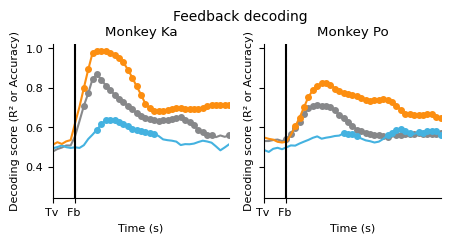

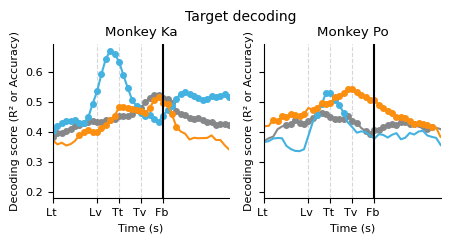

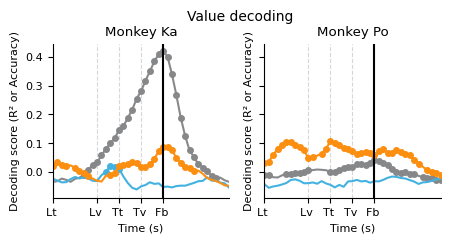

In [3]:
# for each monkey and each target variable (fb, value, target), we plot the 3 areas

plim = .05
N_consecutives = 4

paper_format=True

configs = {
    'feedback': {
        'target': 'feedback',
        't_window': [3, 7],
        'ylim': [-5, 105],
    },
    'target': {
        'target': 'target',
        't_window': [1, 5],
        'ylim': [-5, 105],
    },
    'stay_value': {
        'target': 'stay_value',
        't_window': [1, 5],
        'ylim': [-5, 75],
    }
}

for config_name, config in configs.items():
    target = config['target']
    t_window = config['t_window']
    ylim = config['ylim']

    # load results
    res = load_decoding_res()
    res = add_subareas(res)  # add subareas to the results 
    res = res.sel(target=target)  # select target of interest, e.g. feedback or value

    # mask significants
    res_target_signifs = mask_N_consecutives(res.pvals <= plim, N=N_consecutives)  # mask N consecutive non-significant bins
    res['if_significant'] = res_target_signifs  # add as new dataarray to the results
    #res = mask_negative_scores(res)  # mask negative scores, only for ka monkey

    title = target
    fig, axs = plot_simple_decoding(res, t_window=t_window, mark_event='Fb', title=title)

    plt.show()
    plt.close()
